# Demo for running the code for the manuscript "Towards Enhancing Field-Based Vegetation Monitoring: A Deep Learning Approach for Species Identification and Coverage Estimation from Ground-level Imagery"
This method takes RGB images from the forest floor as input and the output is the percentage coverage of the two target species blueberry and lingonberry inside a reference frame visible in the image.

This demo is intended to be used as an example of the main steps including:
- training: train two models (Frame object detection and Species instance segmentation model) with the images and labels from the dataset *Species_segmentation_data* for the species instance segmentation and *Frame_data* for the frame object detection
- finding the best confidence threshold for inference
- inference: predict on the test images from the dataset *Species_cover_data_test*
- evaluation: evaluate the model by comparing the predictions from  the dataset *Species_cover_data_test* with the estimates from the fieldworkers (*Field_data_NFI*)

## Setup the environment

In [1]:
import ultralytics
from ultralytics import YOLO

import cv2
import numpy as np
import os
import pandas as pd
import shutil
import random

import matplotlib.pyplot as plt

# import function to predict on raw images and estimate percentage cover per species 
from functions import predict_cover, validate_cover, validate_cover, validate_cover_smalloutput

If you get the following error when loading ultralytics:
 
```
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
  File "/path/to/anonymous\AppData\Local\anaconda3\envs\deepView\Lib\site-packages\ultralytics\__init__.py", line 10, in <module>
    from ultralytics.data.explorer.explorer import Explorer
  File "/path/to/anonymous\AppData\Local\anaconda3\envs\deepView\Lib\site-packages\ultralytics\data\__init__.py", line 3, in <module>
    from .base import BaseDataset
  File "/path/to/anonymous\AppData\Local\anaconda3\envs\deepView\Lib\site-packages\ultralytics\data\base.py", line 15, in <module>
    from torch.utils.data import Dataset
  File "/path/to/anonymous\AppData\Local\anaconda3\envs\deepView\Lib\site-packages\torch\__init__.py", line 148, in <module>
    raise err
OSError: [WinError 126] The specified module could not be found. Error loading "/path/to/anonymous\AppData\Local\anaconda3\envs\VegCover\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.
```
 
Then you should follow the Fix n.1 found at https://github.com/ultralytics/ultralytics/issues/15049:
 
```
# Downgrade Pytorch (for CPU)
pip uninstall torch torchvision torchaudio -y
pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cpu
```
Then reinstall the requirements and restart the kernel: 
```
pip install -r requirements.txt
```
 

## Training
Two models are to be trained:
1. Frame object detection model - to cut the images to the inner frame
2. Species instance segmentation model - to segment the two target species blueberry and lingonberry

### Structure of the folder for training the models

### Train the frame object detection model

The following model is trained with a subset of 10 from the available images with labelled frame. Set in the path to the root folder in the *datasets/Frame_data/dataset_demo.yaml*. Example:
```
names:
  0: frame
path: C:\Users\Anonym\VegCover\datasets\Frame_data
train: train_demo
val: val_demo
```

To train the model with all available images with labelled frame use dataset.yaml with your path to the Species_data folder and all available images in *Frame_data/train* and *Frame_data/val*

In [91]:
# path to training data for frame object detection model 
path_to_data_frame="datasets/Frame_data" # path to the root where you have the yaml and the images and labels subfolder

In [101]:
# Set YOLO parameters
IM_SIZE = 640 # Image size for training
N_EPOCHS = 50 # Number of epochs for training
BATCH_SIZE = 4 # Batch size for training
MODEL = 'yolov8n.pt' # Choose pretrained YOLO model version and size

# Train frame detection model
!yolo task=detect mode=train model={MODEL} data="datasets/Frame_data/dataset_demo.yaml" epochs={N_EPOCHS} imgsz={IM_SIZE} batch={BATCH_SIZE} project="Models" name="Frame_detection_model"

# Construct the path to the trained model's best weights
trained_model_path_frame = "Models/Frame_detection_model/weights/best.pt"

New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.76 🚀 Python-3.12.4 torch-2.3.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/Frame_data/dataset_demo.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Models, name=Frame_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

### Train the species instance segmentation model
 Set in the path to the root folder in the *datasets/Species_data/dataset.yaml*. Example:
```
 names:
  0: blueberry
  1: lingonberry
path: C:\Users\anonym\VegCover\datasets\Species_data
train: train
val: val
```


In [2]:
# path to training data for species instance segmentation model 
path_to_data_species="datasets/Species_segmentation_data" # path to the root where you have the yaml and the images and labels subfolder

In [108]:
# Set YOLO parameters
IM_SIZE = 1024 # Image size for training
N_EPOCHS = 50 # Number of epochs for training (Output shows process with only 2 epochs) 
BATCH_SIZE = 8 # Batch size for training
MODEL = 'yolov8s-seg.pt' # Choose pretrained YOLO model version and size

# Train frame detection model
!yolo task=segment mode=train model={MODEL} data="datasets/Species_segmentation_data/dataset.yaml" epochs={N_EPOCHS} imgsz={IM_SIZE} batch={BATCH_SIZE} project="Models" name="Species_segmentation_model_test"

# Construct the path to the trained model's best weights
trained_model_path_frame = "Models/Species_segmentation_model_test/weights/best.pt"

WARNING ⚠️ argument 'data=datasets/Species_data/dataset.yaml,' does not require trailing comma ',', updating to 'data=datasets/Species_data/dataset.yaml'.
WARNING ⚠️ argument 'epochs=2,' does not require trailing comma ',', updating to 'epochs=2'.
WARNING ⚠️ argument 'imgsz=1024,' does not require trailing comma ',', updating to 'imgsz=1024'.
WARNING ⚠️ argument 'batch=8,' does not require trailing comma ',', updating to 'batch=8'.
WARNING ⚠️ argument 'project=Models,' does not require trailing comma ',', updating to 'project=Models'.
New https://pypi.org/project/ultralytics/8.2.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.76 🚀 Python-3.12.4 torch-2.3.1+cpu CPU (Intel Core(TM) i5-6300U 2.40GHz)
engine\trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=datasets/Species_data/dataset.yaml, epochs=2, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=Models, name=Species_segmentati

### Model evaluation with F1, box_loss and seg_loss

When a model is trained, a results.csv file is automatically created. This document contains various values such as map50, precision and recall for the different epochs. These results.csv files were used in the paper to create Figure 2 and can be found here *Models/Frame_detection_model_info* and here *Models/Species_segmentation_model_info* for the two models used in the paper. 

## Finding the confidence threshold for inference

To find the best confidence threshold to predict on the data we use *Species_data_val*. The labels in folder *Species_data_val_threshold* are used to calculate the percentage cover which we then use as ground truth. These validation images and labels are in a separate folder the *Species_data_val* because these images are labelled on the images which are not cut to the inner frame. To compare the percentage coverage calculated from labelling we need the labels on the images which are cut to the inner frame like in *Species_data_val_threshold*. 

Calculate the percentage cover from the images and manually made labels in *Species_data_val_threshold*:

In [22]:
def predict(path_to_data_images,                         # parameter for species segmentation
            number_of_classes=2):                        # parameter for calculating percentage cover

    predicted_images_path = "datasets/Species_segmentation_data/Species_data_val_threshold/images"
    predicted_images_path_labels = "datasets/Species_segmentation_data/Species_data_val_threshold/labels"

    # Create grayscale images and analyze results
    class_intensity_mapping = {i: random.randint(0, 255) for i in range(number_of_classes)}
    intensity_to_class = {v: k for k, v in class_intensity_mapping.items()}

    results = []

    for image_filename in os.listdir(predicted_images_path):
        if image_filename.endswith(".jpg"):
            image_path = os.path.join(predicted_images_path, image_filename)
            label_filename = os.path.splitext(image_filename)[0] + ".txt"
            label_path = os.path.join(predicted_images_path_labels, label_filename)

            image = cv2.imread(image_path)
            height, width, _ = image.shape
            accumulated_mask = np.zeros((height, width), dtype=np.uint8)

            class_pixel_shares = {'Image': image_filename}
            if os.path.exists(label_path):
                with open(label_path, "r") as file:
                    for line in file:
                        class_number = int(line[0])
                        object_info = line.split()[1:]
                        object_info = list(map(float, object_info))
                        coordinates_pairs = np.array(object_info).reshape(-1, 2)
                        coordinates_pairs[:, 0] *= width
                        coordinates_pairs[:, 1] *= height
                        intensity = class_intensity_mapping.get(class_number, 0)
                        mask = np.zeros((height, width), dtype=np.uint8)
                        cv2.fillPoly(mask, [coordinates_pairs.astype(int)], intensity)
                        accumulated_mask = cv2.bitwise_or(accumulated_mask, mask)

                total_pixels = accumulated_mask.size
                unique_classes = np.unique(accumulated_mask)
                for target_class in unique_classes:
                    if target_class == 0:
                        continue
                    class_pixels = np.sum(accumulated_mask == target_class)
                    pixel_share = (class_pixels / total_pixels) * 100
                    class_id = intensity_to_class.get(target_class, "mixed")
                    class_pixel_shares[f'Class_{class_id}'] = pixel_share

            # If no species detected, add NaN or zero values
            if not class_pixel_shares:
                for class_id in range(number_of_classes):
                    class_pixel_shares[f'Class_{class_id}'] = 0

            results.append(class_pixel_shares)

            # Save the grayscale mask
            #mask_filename = os.path.splitext(image_filename)[0] + "_mask.jpg"
            #mask_path = os.path.join(path_to_data_images, mask_filename)
            #cv2.imwrite(mask_path, accumulated_mask)

    results_df = pd.DataFrame(results)
    # Replace NaN with 0
    results_df = results_df.fillna(0)
    results_folder = os.path.join(path_to_data_images, "Results")
    os.makedirs(results_folder, exist_ok=True)
    results_file_path = os.path.join(results_folder, 'results.csv')
    results_df.to_csv(results_file_path, index=False)

    print(f"Results saved to: {results_file_path}")

In [23]:
path_to_data_images = "datasets/Species_segmentation_data/Species_data_val_threshold/images"

predict(path_to_data_images)

Results saved to: datasets/Species_data/val_threshold/images\Results\results.csv


Calculate the percentage covers for the images in *Species_data_val* while using the labels predicted by the model and compare it to the results from *Species_data_val_threshold*:

Running prediction with confidence threshold: 0.08
Results saved to datasets\Species_segmentation_data\Species_data_val\temp_cropped_images
Results saved to datasets\Species_segmentation_data\Species_data_val\temp_species_segmentation
27 labels saved to datasets\Species_segmentation_data\Species_data_val\temp_species_segmentation\labels
Results saved to: datasets/Species_segmentation_data/Species_data_val\Results\results.csv
Validation completed for confidence threshold: 0.08

Running prediction with confidence threshold: 0.09
Results saved to datasets\Species_segmentation_data\Species_data_val\temp_cropped_images
Results saved to datasets\Species_segmentation_data\Species_data_val\temp_species_segmentation
27 labels saved to datasets\Species_segmentation_data\Species_data_val\temp_species_segmentation\labels
Results saved to: datasets/Species_segmentation_data/Species_data_val\Results1\results.csv
Validation completed for confidence threshold: 0.09

Running prediction with confidence 

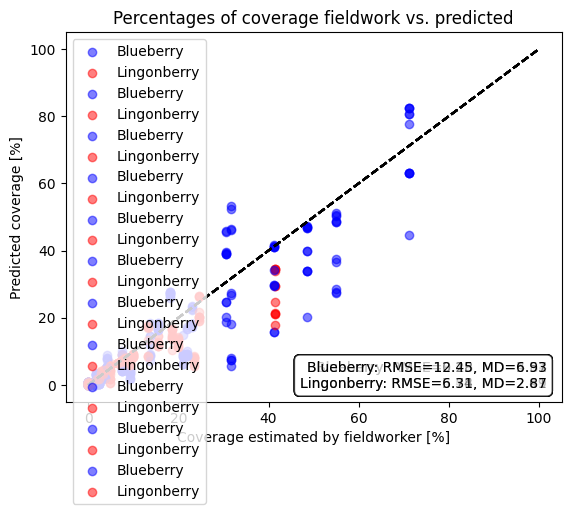

In [2]:
# Define the specific list of confidence thresholds
confidence_thresholds = [0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.179]

# Paths to your data and models
path_to_data_images = "datasets/Species_segmentation_data/Species_data_val"
trained_model_path_frame = "Models/Frame_detection_model.pt"
trained_model_path_species = "Models/Species_segmentation_model.pt"
field_data = pd.read_csv("datasets/Species_segmentation_data/Species_data_val_threshold/images/Results/results.csv") # results from manually labelled images as ground truth 

# List to store confidence thresholds and corresponding RMSE values
rmse_results = []

for i, conf_threshold in enumerate(confidence_thresholds):
    # Create a unique folder name for each threshold iteration
    results_folder_name = f"Results{i if i > 0 else ''}"  # Results, Results1, Results2, etc.

    print(f"Running prediction with confidence threshold: {conf_threshold}")

    # Call the predict_cover function with the current confidence threshold
    predict_cover(
        path_to_data_images=path_to_data_images, 
        path_to_model_frame=trained_model_path_frame, 
        name_frame_class="frame", 
        path_to_model_species=trained_model_path_species, 
        conf_treshold=conf_threshold, 
        number_of_classes=2
    )

    # Construct the path to the results.csv file within the uniquely named folder
    predictions_file = os.path.join(path_to_data_images, results_folder_name, "results.csv")

    # Read the predictions CSV into a DataFrame
    predictions_df = pd.read_csv(predictions_file)


    # Validate the predictions and collect RMSE values
    rmse_list = validate_cover_smalloutput(
        field_data=field_data, 
        predictions=predictions_df, 
        image_ID_column='Image', 
        classes_to_include=['Class_0', 'Class_1'],
        names_of_classes=['Blueberry', 'Lingonberry'],
        colors=['blue', 'red'],
        alpha=0.5
    )
    
    # Store the current confidence threshold and RMSE values in the results list
    rmse_results.append((conf_threshold, rmse_list))
    
    print(f"Validation completed for confidence threshold: {conf_threshold}\n")

# After the loop, print or process the rmse_results list
for conf_threshold, rmses in rmse_results:
    print(f"Threshold: {conf_threshold}, RMSEs: {rmses}")


In [3]:
# Unpack the data into separate lists
column1 = [item[0] for item in rmse_results]
column2 = [item[1][0] for item in rmse_results]
column3 = [item[1][1] for item in rmse_results]

# Create the DataFrame
df = pd.DataFrame({
    'Conf_thres': column1,
    'RMSE_B': column2,
    'RMSE_L': column3
})

# Calculate the Mean_RMSE
df['Mean_RMSE'] = df[['RMSE_B', 'RMSE_L']].mean(axis=1)

Create scatterplot to show the RMSE values for both species for different confidence thresholds: 

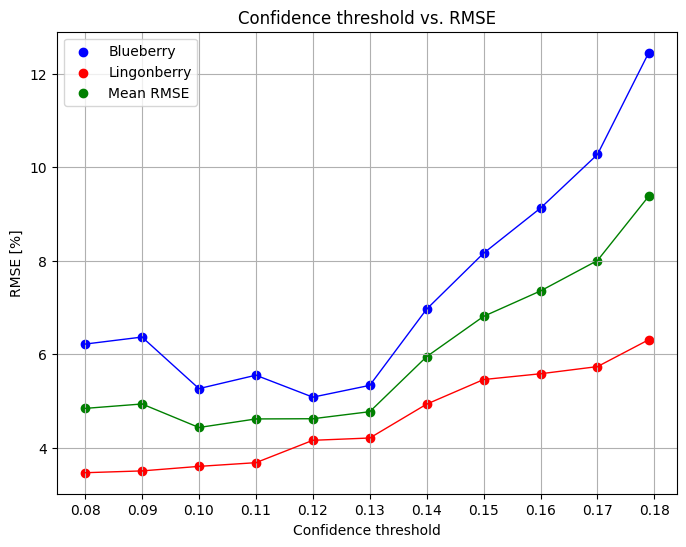

In [4]:
# Create the scatter plot
plt.figure(figsize=(8, 6))

# RMSE_B
plt.scatter(df['Conf_thres'], df['RMSE_B'], color='blue', label='Blueberry')

# RMSE_L
plt.scatter(df['Conf_thres'], df['RMSE_L'], color='red', label='Lingonberry')

# RMSE_Mean
plt.scatter(df['Conf_thres'], df['Mean_RMSE'], color='green', label='Mean RMSE')

# Connecting lines for the blue points
for i in range(len(df['Conf_thres'])-1):
    plt.plot([df['Conf_thres'][i], df['Conf_thres'][i+1]], [df['RMSE_B'][i], df['RMSE_B'][i+1]], color='blue', linestyle='-', linewidth=1)

# Connecting lines for the red points
for i in range(len(df['Conf_thres'])-1):
    plt.plot([df['Conf_thres'][i], df['Conf_thres'][i+1]], [df['RMSE_L'][i], df['RMSE_L'][i+1]], color='red', linestyle='-', linewidth=1)

# Connecting lines for the green points
for i in range(len(df['Conf_thres'])-1):
    plt.plot([df['Conf_thres'][i], df['Conf_thres'][i+1]], [df['Mean_RMSE'][i], df['Mean_RMSE'][i+1]], color='green', linestyle='-', linewidth=1)

# Adjust X-axis
plt.xticks(np.arange(0.08, 0.19, 0.01))

# Label the axes and title
plt.xlabel('Confidence threshold')
plt.ylabel('RMSE [%]')
plt.title('Confidence threshold vs. RMSE')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


## Inference
For applying the models on the test data (*Species_cover_data_test_demo*) the models described in the paper with more training images and epochs are being used. The predict_cover function takes the images taken in the field as input, cuts them to the inner frame with the frame object detection model, applies the species instance segmentation model to detect the species and then determines the coverage of the two target species. From all available 156 test images 100 of these are being used in this demonstration. If you want to use the model on all test data you have to use the images in folder *"Species_cover_data_test"*. 

In [4]:
# load the models used in the paper
trained_model_path_frame = "Models/Frame_detection_model.pt"
trained_model_path_species = "Models/Species_segmentation_model.pt"

In [5]:
# path to test images 
path_to_data_images = "datasets/Species_segmentation_data/Species_cover_data_test_demo" # path to the folder containing the photos taken in the field

# predict on test images 
predict_cover(path_to_data_images, path_to_model_frame=trained_model_path_frame, name_frame_class="frame", # parameter for cropping to frame
            path_to_model_species=trained_model_path_species, conf_treshold=0.10,                     # parameter for species segmentation
            number_of_classes=2)                                                                    # parameter for calculating percentage cover

Results saved to datasets\Species_data\test_demo\temp_cropped_images
Results saved to datasets\Species_data\test_demo\temp_species_segmentation
89 labels saved to datasets\Species_data\test_demo\temp_species_segmentation\labels
Results saved to: datasets/Species_data/test_demo\Results\results.csv


## Evaluation
The estimates of the fieldworkers from (*Field_data_NFI*) are used for the evaluation. For this purpose, the estimates from the coverage percentages of the two species from (*Species_cover_data_test_demo*) are compared with the estimates of the fieldworkers.

In [2]:
field_data =  pd.read_csv("datasets/Field_data_NFI/Fieldworkestimations.csv")
predictions = pd.read_csv("datasets/Species_segmentation_data/Species_cover_data_test_demo/Results/results.csv")

# Remove ".jpg" from each entry in the "Image" column
predictions['Image'] = predictions['Image'].str.replace('.jpg', '')

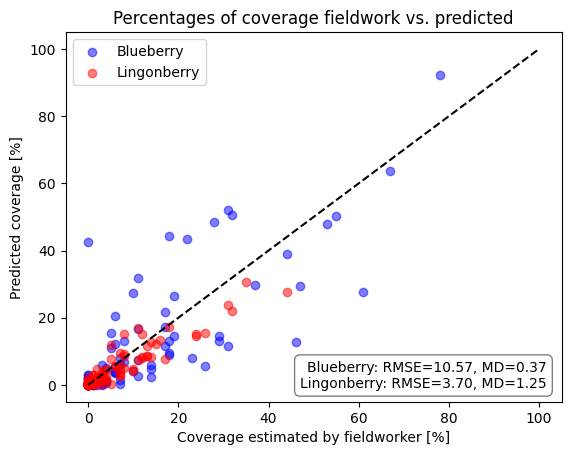

RMSE for Class_0: 10.57214103249792
MD for Class_0: 0.3740004018276512
RMSE for Class_1: 3.700843547515102
MD for Class_1: 1.2501920192274314


[10.57214103249792, 3.700843547515102]

In [3]:
validate_cover(field_data = field_data, # (str) path to field estimations of coverage by fieldworkers
         predictions = predictions, # (str) path to predicted coverage
         image_ID_column = 'Image', # (str) column which exists in both datasets (Image ID)
         classes_to_include = ['Class_0', 'Class_1'],
         names_of_classes = ['Blueberry', 'Lingonberry'],
         colors = ['blue', 'red'],
         alpha = 0.5)

## Feltkurs (additional evaluation) 
The dataset *Field_data_NFI-course* consists of nine ground-level images with estimations of blueberry and lingonberry coverage from 20 fieldworkers from the training course for calibration. Here we use this data to test the models and compare them with the estimates of the fieldworkers. 

In [13]:
# load the models used in the paper
trained_model_path_frame = "Models/Frame_detection_model.pt"
trained_model_path_species = "Models/Species_segmentation_model.pt"

In [14]:
# path to test images 
path_to_data_images = "datasets/Field_data_NFI-course" # path to the folder containing the photos taken in the field

# predict on test images 
predict_cover(path_to_data_images, path_to_model_frame=trained_model_path_frame, name_frame_class="frame", # parameter for cropping to frame
            path_to_model_species=trained_model_path_species, conf_treshold=0.10,                     # parameter for species segmentation
            number_of_classes=2)                                                                    # parameter for calculating percentage cover


Results saved to datasets\Field_data_NFI-Training\temp_cropped_images
Results saved to datasets\Field_data_NFI-Training\temp_species_segmentation
9 labels saved to datasets\Field_data_NFI-Training\temp_species_segmentation\labels
Results saved to: datasets/Field_data_NFI-Training\Results1\results.csv


In [5]:
# Load the estimations from the fieldworker
Lingonberry = pd.read_csv('datasets/Field_data_NFI-course/Lingonberry.csv', sep=',')
Blueberry = pd.read_csv('datasets/Field_data_NFI-course/Blueberry.csv', sep=',')

In [7]:
# Load the results from the prediction on the Field_data_NFI-Training data
Results = pd.read_csv('datasets/Field_data_NFI-course/Results/results.csv')

In [8]:
# Merge the dataset for Blueberry
Blueberry = Blueberry.merge(Results[['Image', 'Class_0']], on='Image', how='left')
Blueberry.rename(columns={'Class_0': 'Prediction'}, inplace=True)

In [9]:
# Merge the dataset for Lingonberry
Lingonberry = Lingonberry.merge(Results[['Image', 'Class_1']], on='Image', how='left')
Lingonberry.rename(columns={'Class_1': 'Prediction'}, inplace=True)

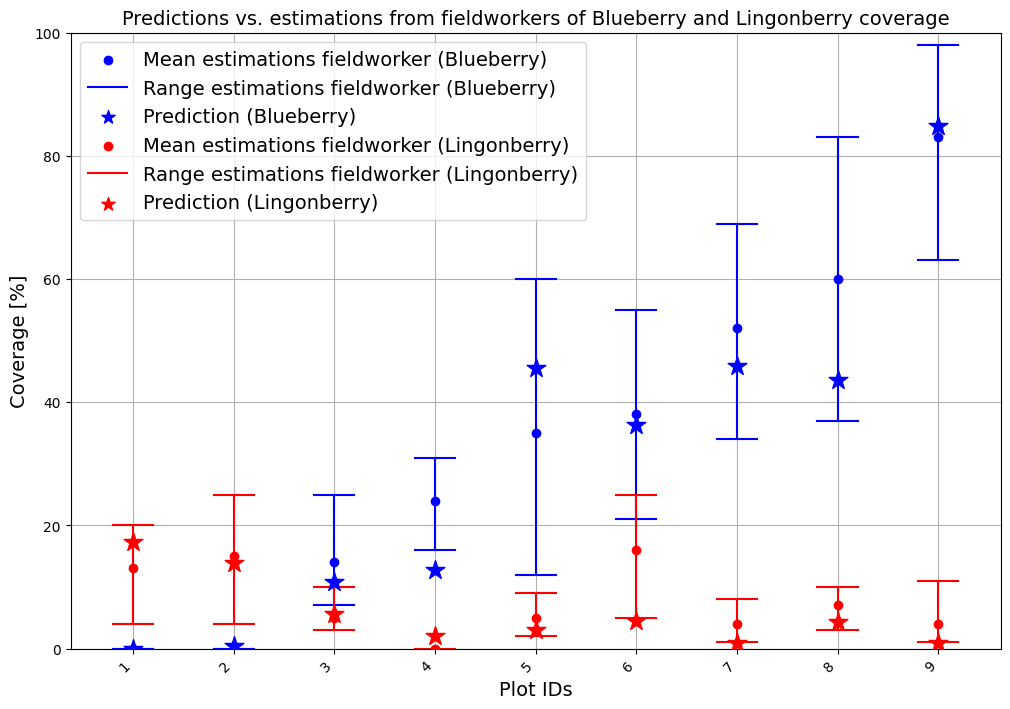

In [10]:
# sort dataframes 
Blueberry_sorted = Blueberry.sort_values(by='Gj.snitt')
Lingonberry_sorted = Lingonberry.sort_values(by='Order')

# Create a new figure
test = plt.figure(figsize=(12, 8))

# Initialize legend handles
mean_estimations_handle_blue = None
range_estimations_handle_blue = None
prediction_handle_blue = None
mean_estimations_handle_red = None
range_estimations_handle_red = None
prediction_handle_red = None

# Plot Blueberry data
for idx, (idx_sorted, row) in enumerate(Blueberry_sorted.iterrows()):
    plt.scatter(idx, row['Gj.snitt'], color='blue', zorder=5)
    plt.plot([idx, idx], [row.iloc[1:21].min(), row.iloc[1:21].max()], color='blue')
    plt.plot([idx - 0.2, idx + 0.2], [row.iloc[1:21].min(), row.iloc[1:21].min()], color='blue')
    plt.plot([idx - 0.2, idx + 0.2], [row.iloc[1:21].max(), row.iloc[1:21].max()], color='blue')
    plt.scatter(idx, row['Prediction'], color='blue', marker='*', s=200, zorder=5)

    if mean_estimations_handle_blue is None:
        mean_estimations_handle_blue = plt.scatter([], [], color='blue', label='Mean estimations fieldworker (Blueberry)')
    if range_estimations_handle_blue is None:
        range_estimations_handle_blue = plt.plot([], [], color='blue', label='Range estimations fieldworker (Blueberry)')[0]
    if prediction_handle_blue is None:
        prediction_handle_blue = plt.scatter([], [], color='blue', marker='*', s=100, label='Prediction (Blueberry)')

# Plot Lingonberry data
for idx, (idx_sorted, row) in enumerate(Lingonberry_sorted.iterrows()):
    plt.scatter(idx, row['Gj.snitt'], color='red', zorder=5)
    plt.plot([idx, idx], [row.iloc[1:21].min(), row.iloc[1:21].max()], color='red')
    plt.plot([idx - 0.2, idx + 0.2], [row.iloc[1:21].min(), row.iloc[1:21].min()], color='red')
    plt.plot([idx - 0.2, idx + 0.2], [row.iloc[1:21].max(), row.iloc[1:21].max()], color='red')
    plt.scatter(idx, row['Prediction'], color='red', marker='*', s=200, zorder=5)

    if mean_estimations_handle_red is None:
        mean_estimations_handle_red = plt.scatter([], [], color='red', label='Mean estimations fieldworker (Lingonberry)')
    if range_estimations_handle_red is None:
        range_estimations_handle_red = plt.plot([], [], color='red', label='Range estimations fieldworker (Lingonberry)')[0]
    if prediction_handle_red is None:
        prediction_handle_red = plt.scatter([], [], color='red', marker='*', s=100, label='Prediction (Lingonberry)')

# Show the legend
plt.legend(handles=[mean_estimations_handle_blue, range_estimations_handle_blue, prediction_handle_blue,
                    mean_estimations_handle_red, range_estimations_handle_red, prediction_handle_red], fontsize = 14)

# Set limits and labels
plt.ylim(0, 100)
plt.xticks(range(max(len(Blueberry_sorted), len(Lingonberry_sorted))), range(1, max(len(Blueberry_sorted), len(Lingonberry_sorted)) + 1), rotation=45, ha='right')
plt.xlabel('Plot IDs', fontsize = 14)
plt.ylabel('Coverage [%]', fontsize = 14)
plt.title('Predictions vs. estimations from fieldworkers of Blueberry and Lingonberry coverage', fontsize = 14)
plt.grid(True)

# Show the plot
plt.show()